<a href="https://colab.research.google.com/github/fmejias/CienciasDeLosDatosTEC/blob/master/MatematicasCienciasDeLosDatos/TP3/TP3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Matemáticas para Ciencias de los Datos
# Trabajo práctico 3

- Professor: M.Sc.Saul Calderon.

- Students: 
    - María Auxiliadora Mora, Instituto Tecnológico de Costa Rica  
    - Felipe Alberto Mejías Loría, Instituto Tecnológico de Costa Rica. 

- June 9th, 2019   

In [0]:
# Libraries required for the exercises
from __future__ import print_function
import torch as torch
import numpy as np
import random
import math

from torch.distributions import constraints
from torch.distributions.distribution import Distribution
from torch.distributions.utils import _standard_normal, lazy_property
from torchvision import datasets, transforms
from torch.distributions import normal
from torch.distributions import multivariate_normal

import torch.distributions as distrib

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from numpy import linalg as linalg

# 1) Genere un conjunto de datos (20 puntos)



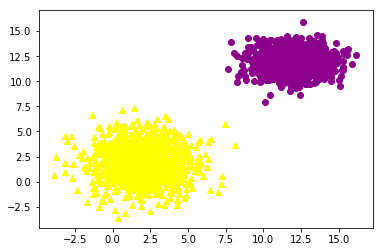

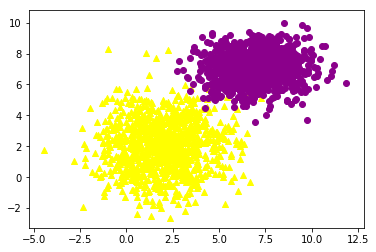

In [5]:
"""
Creates the data to be used for training, using a GMM distribution
@param numberSamplesPerClass, the number of samples per class
@param mean1, means for samples from the class 1
@param mean2, means for samples from the class 2
@param stds1, standard deviation for samples, class 1
@param stds2, standard deviation for samples, class 2
"""
def createData(numberSamplesPerClass = 2, mean1 = [2, 2], mean2 = [6, 6], stds1 = [3, 3], stds2 = [2, 1]):
    '''
    Creates data with gaussian distribution
    '''
    def createDataOneClass(means, covarianceMatrix, numberSamples):
        # Inits the bi gaussian data generator
        multiGaussGenerator = multivariate_normal.MultivariateNormal(means, covarianceMatrix)
        # Takes the samples
        samples = multiGaussGenerator.sample(torch.Size([numberSamples]))
        return samples
   
    means = torch.zeros(2)

    # Ones to concatenate for bias
    ones = torch.ones(numberSamplesPerClass, 1)
    means[0] = mean1[0]
    means[1] = mean1[1]
    # Covariance matrix creation with identity
    covarianceMatrix = torch.eye(2)
    covarianceMatrix[0, 0] = stds1[0]
    covarianceMatrix[1, 1] = stds1[1]
    samplesClass1 = createDataOneClass(means, covarianceMatrix, numberSamplesPerClass)
    means[0] = mean2[0]
    means[1] = mean2[1]
    covarianceMatrix[0, 0] = stds2[0]
    covarianceMatrix[1, 1] = stds2[1]
    samplesClass2 = createDataOneClass(means, covarianceMatrix, numberSamplesPerClass)
    # Concatenates the ones for the bias
    samplesClass1Bias = torch.cat((ones, samplesClass1), 1)
    samplesClass2Bias = torch.cat((ones, samplesClass2), 1)
    samplesAll = torch.cat((samplesClass1, samplesClass2), 0)
    
    #Plot clases
    plt.scatter(samplesClass1[:, 0], samplesClass1[:, 1], marker='^', c='yellow')
    plt.scatter(samplesClass2[:, 0], samplesClass2[:, 1], marker='o', c='darkmagenta')
    plt.show()
  
    #Create samples with bias
    samplesAllBias = torch.cat((samplesClass1Bias, samplesClass2Bias), 0)
    
    #Create targets
    targetsClass1 = torch.ones(numberSamplesPerClass, 1)
    targetsClass2 = -1 * torch.ones(numberSamplesPerClass, 1)
    targetsAll = torch.cat((targetsClass1, targetsClass2), 0)
    
    return (targetsAll, samplesAllBias)
  

  
#1.a) Elija las dispersiones en ambas matrices de covarianza de modo que el conjunto de datos Xa y Ta sea linealmente separable.
# Sample data A
(TargetsAll, SamplesAll) = createData(numberSamplesPerClass = 1000, mean2 = [12, 12])

#1.b) Elija las dispersiones en ambas matrices de covarianza de modo que el conjunto de datos Xb , Tb sea no linealmente separable.
# Los datos deben mezclarse «moderadamente».
# Sample data B
(TargetsAllB, SamplesAllB) = createData(numberSamplesPerClass = 1000, mean2 = [7, 7])
  
  
 

# 2) Estime el vector de pesos óptimo (10 puntos)

In [0]:
def estimateOptimumW(TargetsAll, SamplesAll):
    """ Estimate the optimum W with NO FORS
    param TargetsAll, NumSamples x 1 matrix with target values (1 or -1)
    param SamplesAll, NumSamples x NumDimensions 
    return wOpt, array with optimum weights
    """
    # Calculate w = A*Apinverse*T
    samplesAllPinv = torch.tensor(np.linalg.pinv(SamplesAll))
    wOpt = samplesAllPinv.mm(TargetsAll)
    
    return wOpt
  
# Optimun w for sample data A  
wOpt = estimateOptimumW(TargetsAll, SamplesAll)

# Optimun w for sample data B  
wOptB = estimateOptimumW(TargetsAllB, SamplesAllB)



#3) Estime las salidas implementando la función forward. (20 puntos)

In [0]:
def forward(SamplesAll, wOpt):
    """
    Get model output
    param SamplesAll, NumSamples x NumDimensions 
    return: Estimates the model outputs using the step activation function with values of -1 and 1.   
    """
    EstimatedTargets = SamplesAll.mm(wOpt)
    EstimatedTargets[EstimatedTargets > 0] = 1
    EstimatedTargets[EstimatedTargets <= 0] = -1
     
    return EstimatedTargets

# Estimated target for sample data A    
EstimatedTargetsAll = forward(SamplesAll, wOpt)

# Estimated target for sample data B    
EstimatedTargetsAllB = forward(SamplesAllB, wOptB)

# 4) Evalúe la distancia euclidiana entre la estimación y sus etiquetas. (10 puntos)

In [0]:
def evaluateError(TargetsAll, EstimatedTargetsAll):
    """
    Evaluate model error using the euclidian distance.
    param TargetsAll, real targets
    param EstimatedTargets
    """
    error = torch.norm(TargetsAll - EstimatedTargetsAll, 2)
    return error
  
  
# Error for sample data A    
error = evaluateError(TargetsAll, EstimatedTargetsAll)

# Error for sample data B    
errorB = evaluateError(TargetsAllB, EstimatedTargetsAllB)


# 5) Reporte el error al usar los dos conjuntos de datos generados anteriormente (40 puntos)

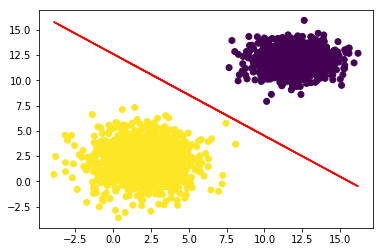

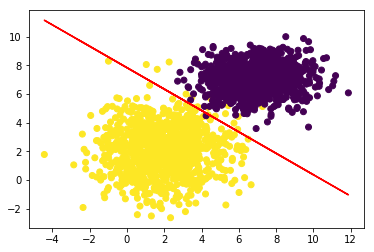

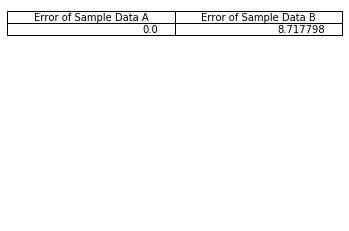

In [18]:
def plotBestFitLine(SamplesAll, wOpt, targets):
    Y = (-wOpt[0] - (wOpt[1] * SamplesAll)) / wOpt[2]
    
    # plot the original data along with our line of best fit
    plt.figure()
    plt.scatter(SamplesAll[:, 1].numpy(), SamplesAll[:, 2].numpy(), marker="o", c=targets.transpose(0, 1)[0])
    plt.plot(SamplesAll.numpy(), Y.numpy(), "r-")
    
    
# Plot best line fit for sample data A
plotBestFitLine(SamplesAll, wOpt, TargetsAll)


# Plot best line fit for sample data B
plotBestFitLine(SamplesAllB, wOptB, TargetsAllB)

#Print errors
fig, ax = plt.subplots()

# Hide axes
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False)
ax.axis("off")

collabel=("Error of Sample Data A", "Error of Sample Data B")
ax.table(cellText=[[error.numpy(),errorB.numpy()]],colLabels=collabel,loc='upper center')
